In [80]:
import pickle
import librosa
import pandas as pd
import scipy as sp
import numpy as np
import sklearn
from datetime import datetime
from sklearn import metrics
from scipy import integrate
import matplotlib.pyplot as plt
import ghostipy
from ghostipy.spectral.wavelets import MorseWavelet
from ghostipy.plotting.core import plot_wavelet_spectrogram

In [2]:
model_dir = 'model/'
data_huawei = "dataset/Accelerometer.csv"
data_samsung = "dataset/Accelerometer_samsung.csv"
data_uncalibrated_samsung = "dataset/AccelerometerUncalibrated_samsung.csv"
feature_matrix_dir = 'feature_matrix'

In [3]:
df_huawei = pd.read_csv(data_huawei)
df_samsung = pd.read_csv(data_samsung)
df_samsung_uncalibrated = pd.read_csv(data_uncalibrated_samsung)

In [97]:
# Set desired frequency (100Hz = 10ms; 63Hz = 15.873016ms; 50Hz = 20ms)
desired_frequency = "20ms"
# Set window size
window_size = 100

# Function to convert epoch time to regular time
def convert_epoch_to_datetime(epoch_time):
    t = epoch_time
    while t >= 10e+9:
        t /= 10
    t = round(t, 2)
    return t


# Function to datetime to string
def convert_datetime_to_string(time):
    time = str(time)
    ms_separator = "."
    # Check if time has milliseconds (indicated by numbers following DOT)
    if ms_separator in time:
        # If so keep only till second decimal
        time_parts = time.split(".", 1)
        time = time_parts[0] + ms_separator + time_parts[1][:2]
    else:
        # Else add zeros till second decimal
        time += ".00"
    return time


# Read CSVs
df1 = df_huawei
df2 = df_samsung
df3 = df_samsung_uncalibrated

# Find min-max time
starting_time_df1 = df1["time"].min()
starting_time_df2 = df2["time"].min()
starting_time_df3 = df3["time"].min()

ending_time_df1 = df1["time"].max()
ending_time_df2 = df2["time"].max()
ending_time_df3 = df3["time"].max()

max_starting_time = max(starting_time_df1, starting_time_df2, starting_time_df3)
min_ending_time = min(ending_time_df1, ending_time_df2, ending_time_df3)

# Keeps common starting-ending time, remove else
df1 = df1[df1["time"] >= max_starting_time]
df2 = df2[df2["time"] >= max_starting_time]
df3 = df3[df3["time"] >= max_starting_time]

df1 = df1[df1["time"] <= min_ending_time]
df2 = df2[df2["time"] <= min_ending_time]
df3 = df3[df3["time"] <= min_ending_time]


# Reset dataframe index
df1 = df1.reset_index(drop=True)
df2 = df2.reset_index(drop=True)
df3 = df3.reset_index(drop=True)

# Convert epoch times to datetime objects
df1["time"] = df1["time"].apply(convert_epoch_to_datetime)
df2["time"] = df2["time"].apply(convert_epoch_to_datetime)
df3["time"] = df3["time"].apply(convert_epoch_to_datetime)

df1["time"] = pd.to_datetime(df1["time"], unit="s")
df2["time"] = pd.to_datetime(df2["time"], unit="s")
df3["time"] = pd.to_datetime(df3["time"], unit="s")

resampled_df_huawei = df1.resample(desired_frequency, on="time").mean().ffill().bfill()

desired_frequency = "15.873016ms"

resampled_df_samsung = df2.resample(desired_frequency, on="time").mean().ffill().bfill()
resampled_df_samsung_uncalibrated = df3.resample(desired_frequency, on="time").mean().ffill().bfill()

In [98]:
mean_acc_huawei = (resampled_df_huawei['y']).mean()
mean_acc_samsung = (resampled_df_samsung['z']).mean()
mean_acc_samsung_uncalib = (resampled_df_samsung_uncalibrated['z']).mean()

min_acc_huawei = (resampled_df_huawei['y']).min()
min_acc_samsung = (resampled_df_samsung['z']).min()
min_acc_samsung_uncalib = (resampled_df_samsung_uncalibrated['z']).min()

max_acc_huawei = (resampled_df_huawei['y']).max()
max_acc_samsung = (resampled_df_samsung['z']).max()
max_acc_samsung_uncalib = (resampled_df_samsung_uncalibrated['z']).max()

In [99]:
print(f'Mean acceleration huawei y direction: {mean_acc_huawei}')
print(f'Mean acceleration samsung z direction: {mean_acc_samsung}')
print(f'Mean acceleration samsung uncalibrated z direction: {mean_acc_samsung_uncalib}')

print(f'Minimum acceleration huawei y direction: {min_acc_huawei}')
print(f'Minimum acceleration samsung z direction: {min_acc_samsung}')
print(f'Minimum acceleration samsung uncalibrated z direction: {min_acc_samsung_uncalib}')

print(f'Maximimum acceleration huawei y direction: {max_acc_huawei}')
print(f'Maximimum acceleration samsung z direction: {max_acc_samsung}')
print(f'Maximimum acceleration samsung uncalibrated z direction: {max_acc_samsung_uncalib}')

Mean acceleration huawei y direction: 0.03834954295657477
Mean acceleration samsung z direction: -0.02236450011646891
Mean acceleration samsung uncalibrated z direction: 9.72570526886506
Minimum acceleration huawei y direction: -15.683449268341064
Minimum acceleration samsung z direction: -34.235618591308594
Minimum acceleration samsung uncalibrated z direction: -48.5161018371582
Maximimum acceleration huawei y direction: 16.168099880218506
Maximimum acceleration samsung z direction: 33.684043884277344
Maximimum acceleration samsung uncalibrated z direction: 46.56003952026367


In [100]:
acceleration_y_huawei = list(resampled_df_huawei['y'])
time_huawei = list(resampled_df_huawei['seconds_elapsed'])

acceleration_z_samsung = list(resampled_df_samsung['z'])
time_samsung = list(resampled_df_samsung['seconds_elapsed'])

acceleration_z_samsung_uncalib = list(resampled_df_samsung_uncalibrated['z'])
time_samsung_uncalib = list(resampled_df_samsung_uncalibrated['seconds_elapsed'])

In [101]:
def calculate_series(acceleration, time):
    velocity = sp.integrate.cumtrapz(acceleration, time, initial=0)
    displacement = sp.integrate.cumtrapz(velocity, time, initial=0)
    jerk = [x - acceleration[i - 1] for i, x in enumerate(acceleration)][1:]
    
    return velocity, displacement, jerk

In [102]:
def plot_time_series(acceleration, velocity, displacement, jerk, time):
    fig, ax = plt.subplots(2, 2, figsize=(20, 10))
    fig.tight_layout(pad=6.0)

    plt.subplot(4, 1, 1)
    plt.title('Acceleration')
    plt.plot(time, acceleration)

    plt.subplot(4, 1, 2)
    plt.plot(time, velocity)
    plt.title('Velocity')

    plt.subplot(4, 1, 3)
    plt.plot(time, displacement)
    plt.title('Displacement')

    plt.subplot(4, 1, 4)
    plt.plot(time[:len(jerk)], jerk)
    plt.title('Jerk')
    plt.show()

In [103]:
# Implement sliding window on the whole dataset
def calculate_samples(acceleration, velocity, displacement, jerk, time):
    window_size = 200
    acceleration_windows = []
    
    i = 0
    while i <= (len(acceleration) - window_size + 1):
        acceleration_windows.append(acceleration[i: i + window_size])
        i = i + window_size
    
    i = 0
    velocity_windows = []
    while i <= (len(velocity) - window_size + 1):
        velocity_windows.append(velocity[i: i + window_size])
        i = i + window_size
    
    i = 0
    displacement_windows = []
    while i <= (len(displacement) - window_size + 1):
        displacement_windows.append(displacement[i: i + window_size])
        i = i + window_size
    
    i = 0
    jerk_windows = []
    while i <= (len(jerk) - window_size + 1):
        jerk_windows.append(jerk[i: i + window_size])
        i = i + window_size
    
    i = 0
    time_windows = []
    while i <= (len(time) - window_size + 1):
        time_windows.append(time[i: i + window_size])
        i = i + window_size
        
    return acceleration_windows, velocity_windows, displacement_windows, jerk_windows, time_windows

In [104]:
# len(acceleration_y_huawei)
len(acceleration_windows_huawei)

308

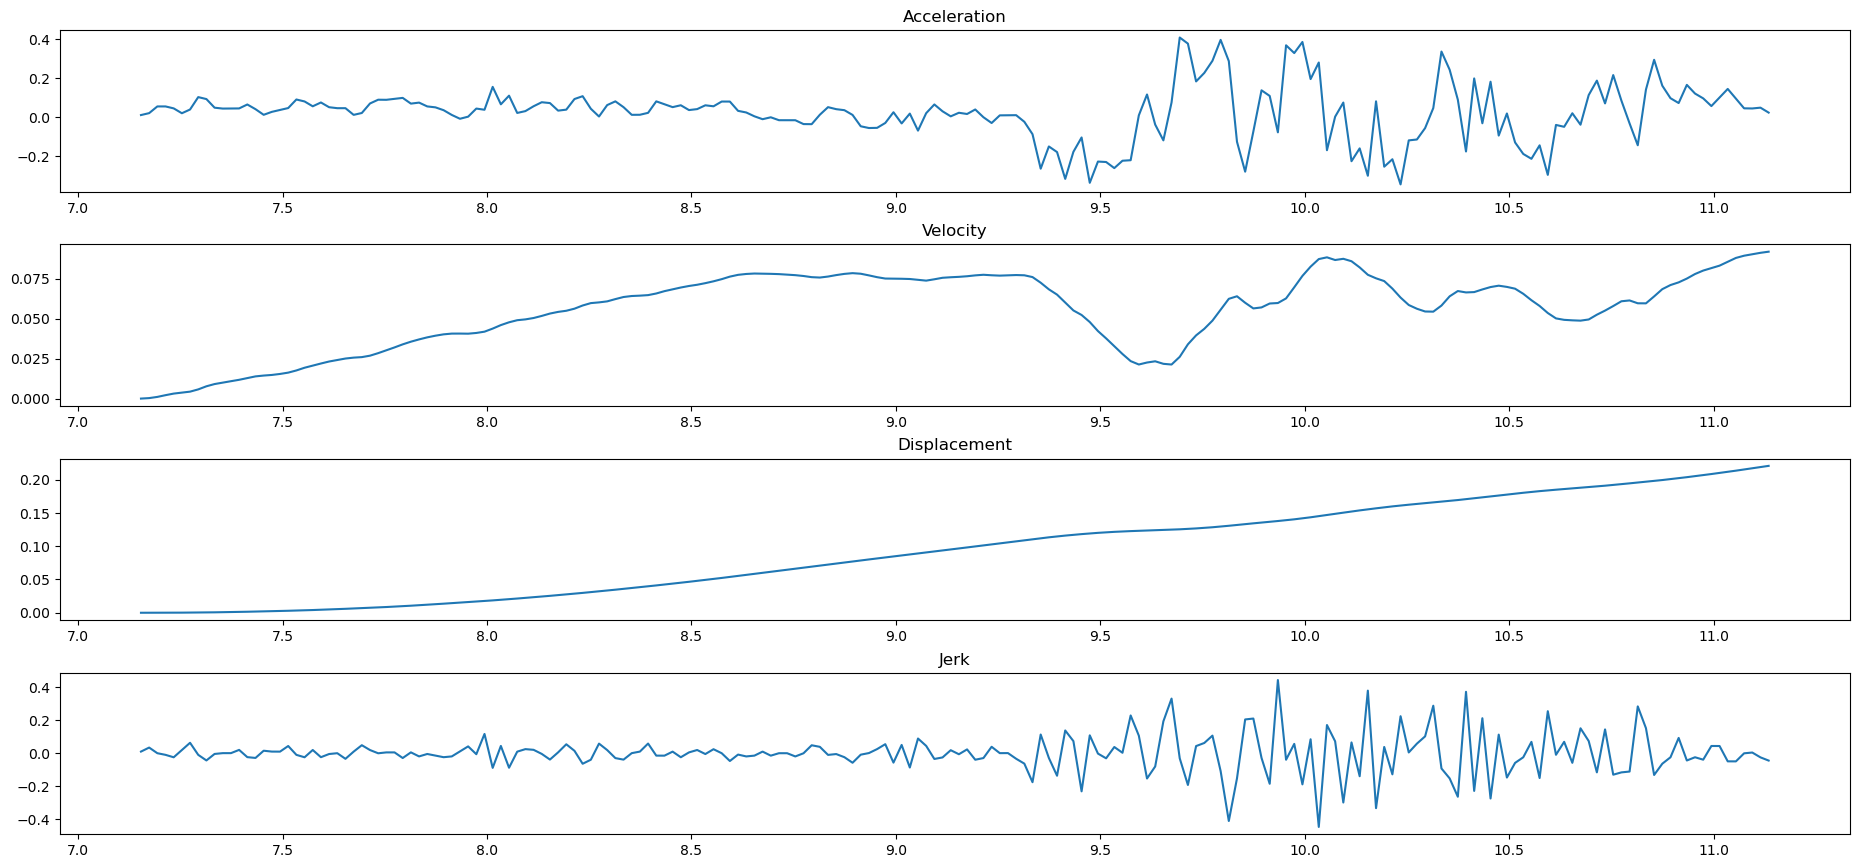

In [105]:
sample_number = 0
velocity_huawei, displacement_huawei, jerk_huawei = calculate_series(acceleration_y_huawei, time_huawei)
acceleration_windows_huawei, velocity_windows_huawei, displacement_windows_huawei, jerk_windows_huawei, time_windows_huawei = calculate_samples(acceleration_y_huawei, velocity_huawei, displacement_huawei, jerk_huawei, time_huawei)
plot_time_series(acceleration_windows_huawei[sample_number], velocity_windows_huawei[sample_number], displacement_windows_huawei[sample_number], jerk_windows_huawei[sample_number], time_windows_huawei[sample_number])

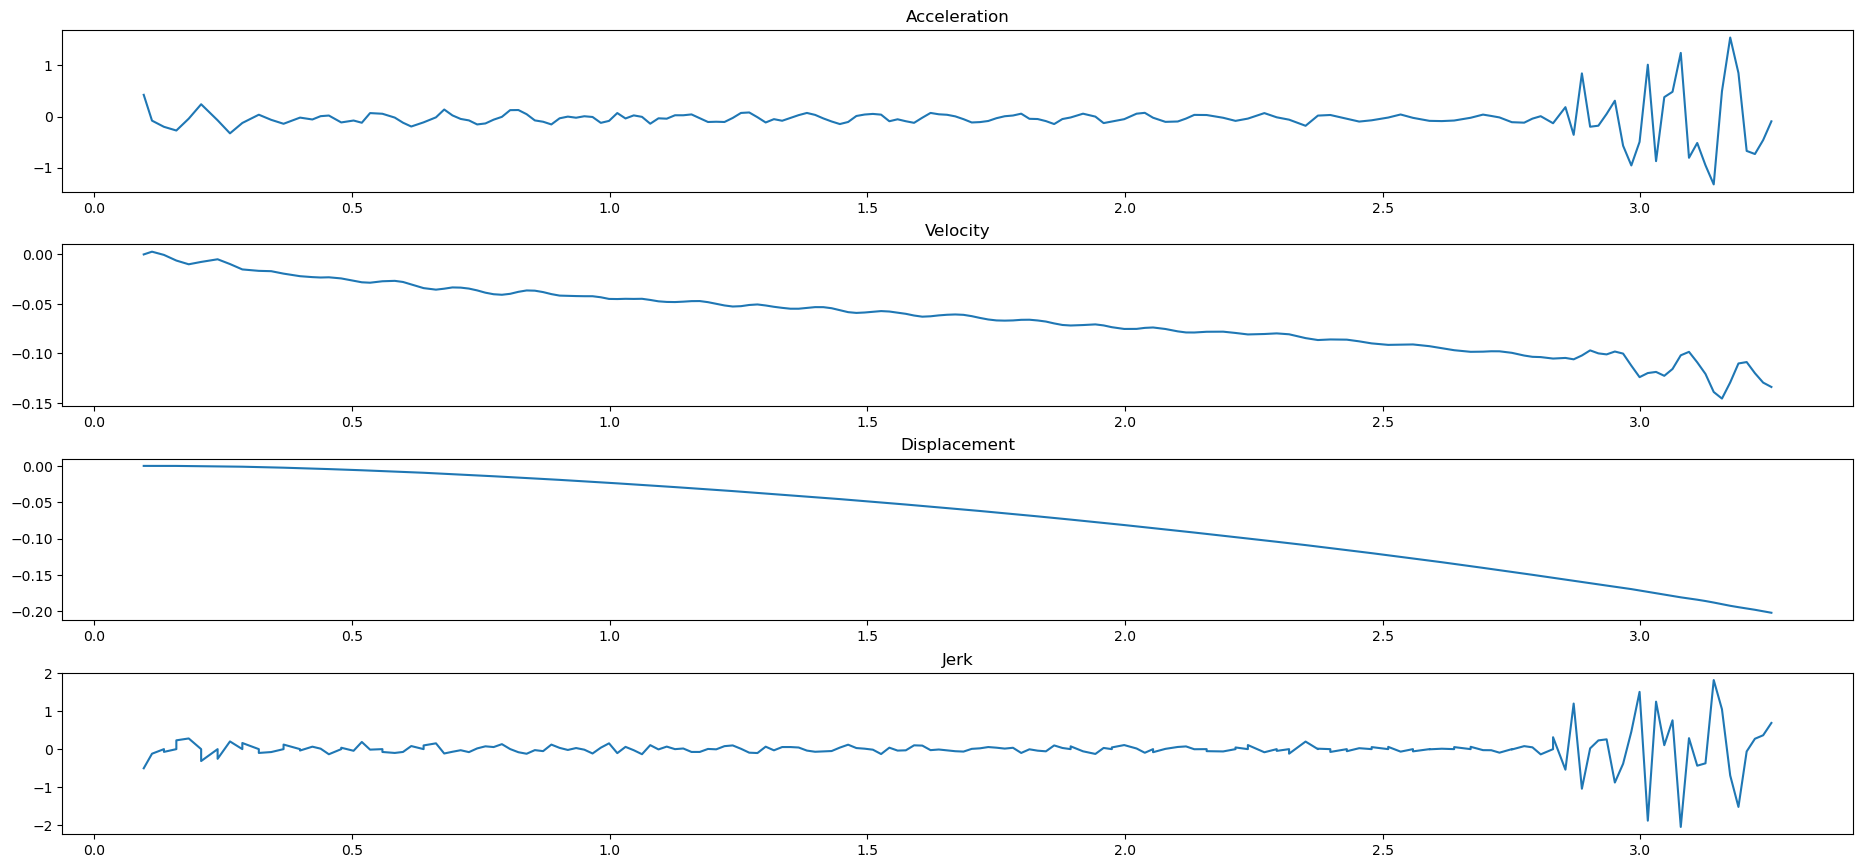

In [106]:
sample_number = 0
velocity_samsung, displacement_samsung, jerk_samsung = calculate_series(acceleration_z_samsung, time_samsung)
acceleration_windows_samsung, velocity_windows_samsung, displacement_windows_samsung, jerk_windows_samsung, time_windows_samsung = calculate_samples(acceleration_z_samsung, velocity_samsung, displacement_samsung, jerk_samsung, time_samsung)
plot_time_series(acceleration_windows_samsung[sample_number], velocity_windows_samsung[sample_number], displacement_windows_samsung[sample_number], jerk_windows_samsung[sample_number], time_windows_samsung[sample_number])

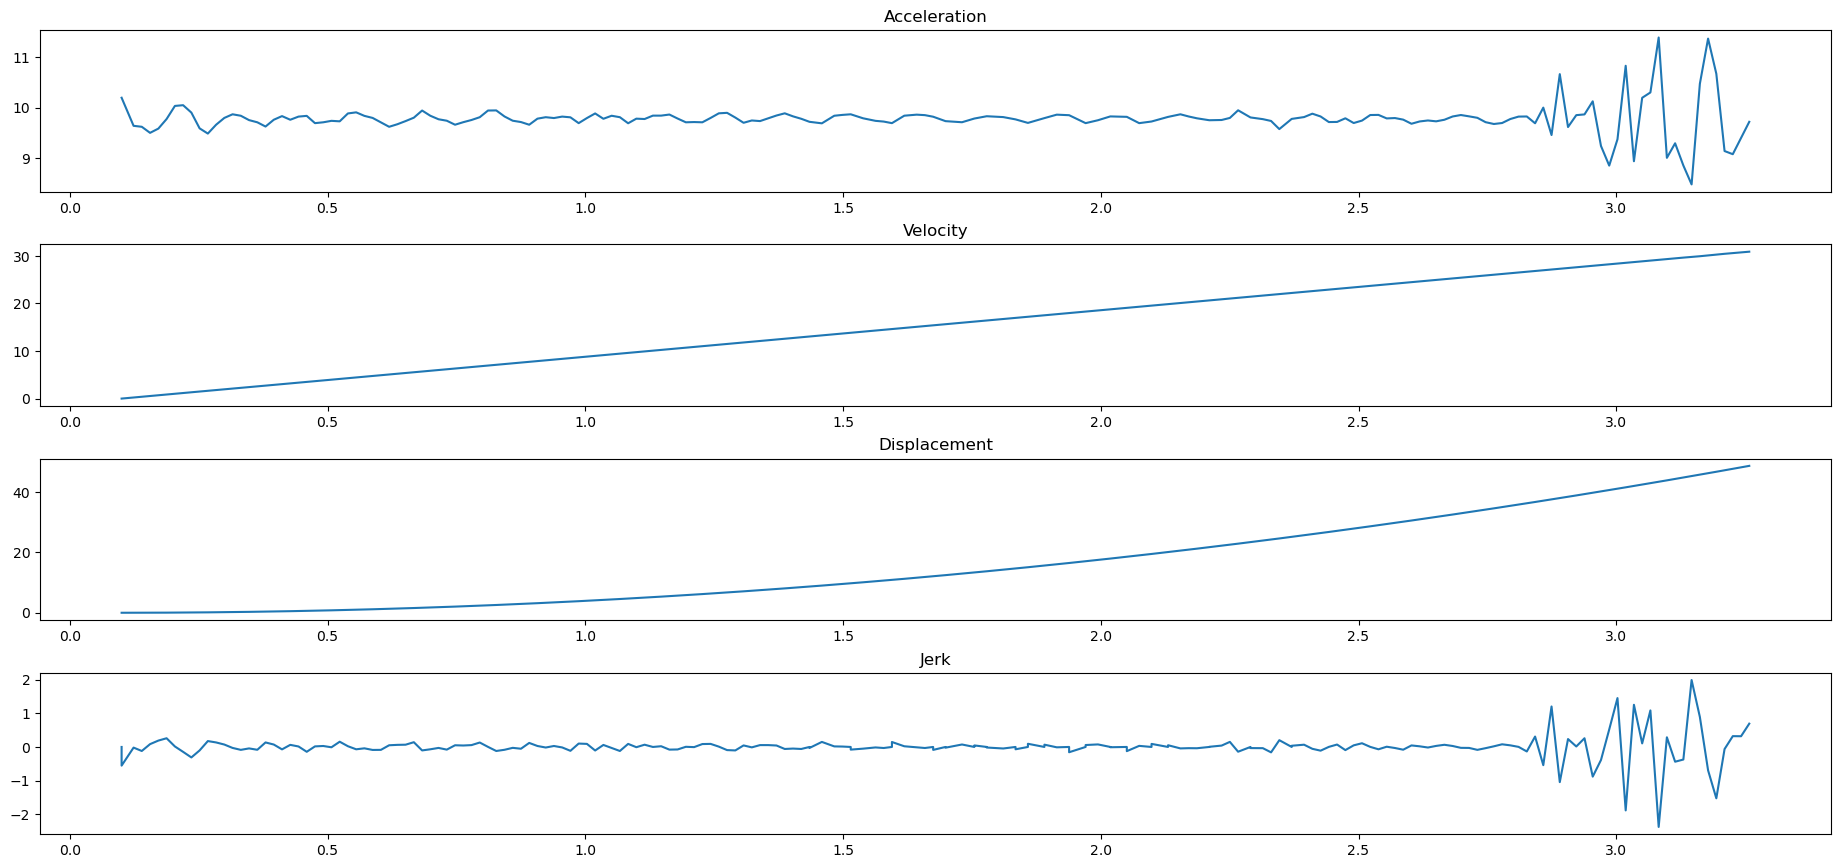

In [107]:
sample_number = 0
velocity_samsung_uncalib, displacement_samsung_uncalib, jerk_samsung_uncalib = calculate_series(acceleration_z_samsung_uncalib, time_samsung_uncalib)
acceleration_windows_samsung, velocity_windows_samsung, displacement_windows_samsung, jerk_windows_samsung, time_windows_samsung = calculate_samples(acceleration_z_samsung_uncalib, velocity_samsung_uncalib, displacement_samsung_uncalib, jerk_samsung_uncalib, time_samsung_uncalib)
plot_time_series(acceleration_windows_samsung[sample_number], velocity_windows_samsung[sample_number], displacement_windows_samsung[sample_number], jerk_windows_samsung[sample_number], time_windows_samsung[sample_number])

In [50]:
def compute_feature_vector(acceleration, velocity, displacement, jerk, time):
    """
    Returns the feature matrix given multiple time series data
    """
    acceleration = np.array(acceleration)
    velocity = np.array(velocity)
    displacement = np.array(displacement)
    jerk = np.array(jerk)

    time_series_data = [acceleration, velocity, displacement, jerk]
    feature_vector = []

    for data in time_series_data:
        feature_vector.append(np.mean(data))
        feature_vector.append(np.std(data))
        feature_vector.append(sp.integrate.trapz(acceleration, time))
        feature_vector.extend(np.percentile(data, q=[0, 100]))
        feature_vector.append(float(librosa.feature.zero_crossing_rate(y=data)))
        feature_vector.append(float(librosa.feature.spectral_flatness(n_fft=400, y=data)))
        feature_vector.append(float(librosa.feature.spectral_centroid(n_fft=400, y=data)))
        feature_vector.append(float(librosa.feature.spectral_rolloff(n_fft=400, y=data)))
        feature_vector.append(float(librosa.feature.spectral_bandwidth(n_fft=400, y=data)))
        feature_vector.extend(np.percentile(data, q=[25, 50, 75]))
    
    return(feature_vector)

In [51]:
def calculate_feature_matrix(phone, acceleration, velocity, displacement, jerk, time):
    feature_matrix = []
    acceleration_windows, velocity_windows, displacement_windows, jerk_windows, time_windows = calculate_samples(acceleration, velocity,
                                                                                                                 displacement, jerk, time)
    n_samples = len(jerk_windows)
    for i in range(n_samples):
        feature_vector = compute_feature_vector(acceleration_windows[i], velocity_windows[i], 
                                                displacement_windows[i], jerk_windows[i], time_windows[i])
        feature_matrix.append(feature_vector)
        if (i % 10000) == 0:
            print(f'Number of samples processed on {phone} data: {i}')

    with open(f"{feature_matrix_dir}/feature_matrix_{phone}.pkl", "wb") as f:   #Pickling
        pickle.dump(feature_matrix, f)

In [52]:
##----------------------------Build feature matrix and store it as a pickle file---------------------------#
# calculate_feature_matrix('huawei' , acceleration_y_huawei, velocity_huawei, displacement_huawei, jerk_huawei, time_huawei)
# calculate_feature_matrix('samsung', acceleration_z_samsung, velocity_samsung, displacement_samsung, jerk_samsung, time_samsung)
# calculate_feature_matrix('samsung_uncalibrated', acceleration_z_samsung_uncalib, velocity_samsung_uncalib, displacement_samsung_uncalib, jerk_samsung_uncalib, time_samsung_uncalib)

In [53]:
def get_feature_matrix(phone):
    with open(f"{feature_matrix_dir}/feature_matrix_{phone}.pkl", "rb") as f:  
        feature_matrix = pickle.load(f)
    
    return feature_matrix

In [54]:
# Load the model from the pickle file
n_estimators = 400 # Change the number of estimators
with open(f'{model_dir}/pothole_depth_{n_estimators}estimators.pkl', 'rb') as f:
    regressor = pickle.load(f)

In [55]:
# Evaluating the Algorithm
feature_matrix_huawei = get_feature_matrix('huawei')
output_huawei = regressor.predict(feature_matrix_huawei)
output_huawei

array([10.585 , 10.585 , 10.5975, ...,  7.435 ,  7.44  ,  7.415 ])

In [56]:
feature_matrix_samsung = get_feature_matrix('samsung')
output_samsung = regressor.predict(feature_matrix_samsung)
output_samsung

array([10.88625, 10.87   , 10.77875, ...,  7.5875 ,  7.49625,  7.58   ])

In [57]:
feature_matrix_samsung_uncalibrated = get_feature_matrix('samsung_uncalibrated')
output_samsung_uncalibrated = regressor.predict(feature_matrix_samsung_uncalibrated)
output_samsung_uncalibrated

array([10.08375, 10.15625, 10.09875, ...,  7.05375,  7.1975 ,  7.02125])

In [58]:
print(f'Mean depth huawei: {output_huawei.mean()}')
print(f'Mean depth samsung: {output_samsung.mean()}')
print(f'Mean depth samsung uncalibrated: {output_samsung_uncalibrated.mean()}')

print(f'Minimum depth huawei: {output_huawei.min()}')
print(f'Minimum depth samsung: {output_samsung.min()}')
print(f'Minimum depth samsung uncalibrated: {output_samsung_uncalibrated.min()}')

print(f'Maximimum depth huawei: {output_huawei.max()}')
print(f'Maximimum depth samsung: {output_samsung.max()}')
print(f'Maximimum depth samsung uncalibrated: {output_samsung_uncalibrated.max()}')

Mean depth huawei: 12.779096911551788
Mean depth samsung: 13.54912517691269
Mean depth samsung uncalibrated: 13.016294432243372
Minimum depth huawei: 5.985
Minimum depth samsung: 7.02125
Minimum depth samsung uncalibrated: 6.2425
Maximimum depth huawei: 15.77875
Maximimum depth samsung: 15.83125
Maximimum depth samsung uncalibrated: 14.135


## Pothole Detection
Implementing crack detection on our data using [Generalized Morse Wavelets parameter selection and transfer learning for pavement transverse cracking detection](https://www.sciencedirect.com/science/article/pii/S0952197623005390?via%3Dihub)

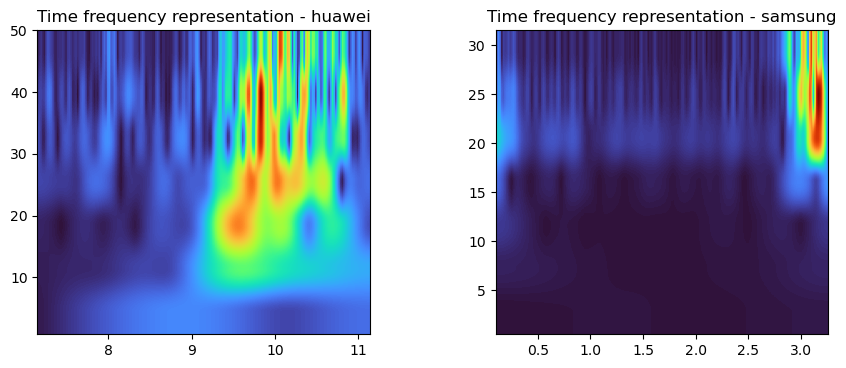

In [117]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(pad=6.0)

run_number = 0 # The acceleration series number 

# Find the generalized morse wavelet transform for acceleration data for roads which are cracked.
gmw = MorseWavelet(gamma=3, beta=1.3333)
x = acceleration_windows_huawei[run_number]
x = np.array(x)
Wx, scale, freq, *_  = ghostipy.spectral.cwt(x, timestamps=time_windows_huawei[run_number], 
                                                         fs=100, wavelet=gmw, voices_per_octave=1)
ax[0].set_title('Time frequency representation - huawei')
ax[0].imshow(np.abs(Wx), aspect='auto', cmap='turbo',  
             extent=[time_windows_huawei[run_number][0], time_windows_huawei[run_number][-1], freq[-1], freq[0]]
            )

gmw = MorseWavelet(gamma=3, beta=1.3333)
x = acceleration_windows_samsung[0]
x = np.array(x)
Wx, scale, freq, *_ = ghostipy.spectral.cwt(x, timestamps=time_windows_samsung[run_number], 
                                            fs=63, wavelet=gmw, voices_per_octave=1)
ax[1].set_title('Time frequency representation - samsung')
ax[1].imshow(np.abs(Wx), aspect='auto', cmap='turbo', 
             extent=[time_windows_samsung[run_number][0], time_windows_samsung[run_number][-1], freq[-1], freq[0]]
            )

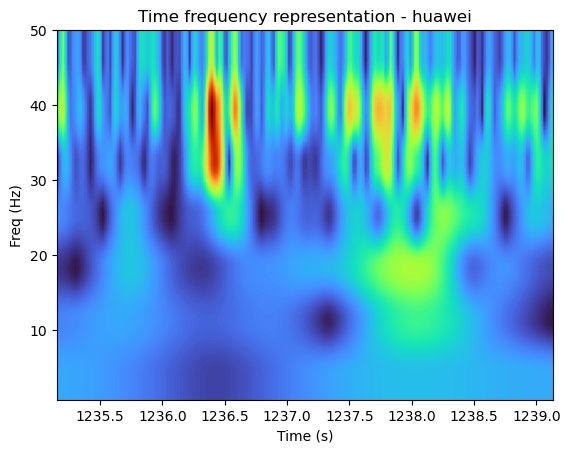

In [128]:
# Extract scalograms from huawei data and save
gmw = MorseWavelet(gamma=3, beta=1.3333)

for i, acceleration_window in enumerate(acceleration_windows_huawei):
    x = acceleration_window
    x = np.array(x)
    Wx, scale, freq, *_  = ghostipy.spectral.cwt(x, timestamps=time_windows_huawei[run_number], 
                                                         fs=100, wavelet=gmw, voices_per_octave=1)
    plt.title('Time frequency representation - huawei')
    plt.imshow(np.abs(Wx), aspect='auto', cmap='turbo',  
             extent=[time_windows_huawei[i][0], time_windows_huawei[i][-1], freq[-1], freq[0]]
            )    
    plt.xlabel('Time (s)')
    plt.ylabel('Freq (Hz)')
    plt.savefig(f'./huawei_scalogram_images/huawei_scalogram_{i}.png')